# Prediction of compond solubility using  GBD database

##### Adapted from the notebook in this webpage: https://www.moreisdifferent.com/2017/9/21/DIY-Drug-Discovery-using-molecular-fingerprints-and-machine-learning-for-solubility-prediction/

In [1]:
!pip install kora
import kora.install.rdkit

     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 61kB 4.2MB/s 


In [2]:
from rdkit import Chem 
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from rdkit.Chem.rdmolops import RDKFingerprint
import pandas as pd
import numpy as np
from  sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from keras import regularizers
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

In [3]:
from google.colab import files
uploaded=files.upload()

Saving training_set.csv to training_set.csv


In [16]:
raw=pd.read_csv('training_set.csv')

In [17]:
data=raw[['SMILES', 'logKp']]

In [18]:
def estate_fingerprint_and_mw(mol):
  return np.append(FingerprintMol(mol)[0], Descriptors.MolWt(x))

In [19]:
data['Mol']=data['SMILES'].apply(Chem.MolFromSmiles)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
data

,SMILES,logKp,Mol
0,C(CC(=O)O)C(=O)CN,-4.15,<rdkit.Chem.rdchem.Mol object at 0x7efdb2a83a30>
1,C(C(=O)NC(CC1=CNC2=CC=CC=C21)C(=O)O)N,-4.82,<rdkit.Chem.rdchem.Mol object at 0x7efdb2a8d080>
2,C(C(=O)O)N,-4.42,<rdkit.Chem.rdchem.Mol object at 0x7efdb2a8d4e0>
3,C(CCN)CC(C(=O)O)N,-4.77,<rdkit.Chem.rdchem.Mol object at 0x7efdb2a8dd00>
4,C(C(C(=O)O)N)C(=O)O,-5.03,<rdkit.Chem.rdchem.Mol object at 0x7efdb2a8dee0>
...,...,...,...
158,C[C@@H]1CC[C@H]([C@@H](C1)O)C(=C)C,-3.72,<rdkit.Chem.rdchem.Mol object at 0x7efdb2a4b4e0>
159,C[C@@H]1CCC(=C(C)C)C(=O)C1,-2.87,<rdkit.Chem.rdchem.Mol object at 0x7efdb2a4b530>
160,CC1=CC(=C(C=C1)C(C)C)O,-3.74,<rdkit.Chem.rdchem.Mol object at 0x7efdb2a4b670>
161,CC1=CCC(CC1O)C(=C)C,-2.91,<rdkit.Chem.rdchem.Mol object at 0x7efdb2a4b620>


In [21]:
y=data['logKp'].apply(lambda x: float(x.replace(',', '.'))).values

In [22]:
import rdkit.Chem.rdMolDescriptors
from rdkit.Chem.rdMolDescriptors import GetHashedAtomPairFingerprintAsBitVect, GetHashedTopologicalTorsionFingerprintAsBitVect
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect, GetErGFingerprint
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import rdkit.DataStructs.cDataStructs

In [23]:
def ExplicitBitVect_to_NumpyArray(bitvector):
    bitstring=bitvector.ToBitString()
    intmap=map(int, bitstring)
    return np.array(list(intmap))


class fingerprint():
    def __init__(self, fp_fun, name):
        self.fp_fun=fp_fun
        self.name=name
        self.x=[]
    def apply_fp(self, mols):
        for mol in mols:
            fp = self.fp_fun(mol)
            if isinstance(fp,tuple):
                fp=np.array(list(fp[0]))
            if isinstance(fp, rdkit.DataStructs.cDataStructs.ExplicitBitVect):
                fp=ExplicitBitVect_to_NumpyArray(fp)
            if isinstance(fp, rdkit.DataStructs.cDataStructs.IntSparseIntVect):
                fp=np.array(list(fp))

            self.x+=[fp]

            if (str(type(self.x[0]))!="<class 'numpy.ndarray'>"):
                print("WARNING: type for ", self.name, "is ", type(self.x[0]))


def make_fingerprints(length=512, verbose=False):
    fp_list=[
       # fingerprint(lambda x : GetBPFingerprint(x), 
        #             "Physiochemical properties (1996)"), 
             
             ##NOTE: takes a long time to compute
         fingerprint(lambda x : GetHashedAtomPairFingerprintAsBitVect(x, nBits = length),"Atom pair (1985)"),
         fingerprint(lambda x : GetHashedTopologicalTorsionFingerprintAsBitVect(x, nBits = length),
                     "Topological torsion (1987)"),
         fingerprint(lambda x : GetMorganFingerprintAsBitVect(x, 2, nBits = length),
                     "Morgan circular "),
         fingerprint(FingerprintMol, "Estate (1995)"),
         fingerprint(lambda x: GetAvalonFP(x, nBits=length),
                    "Avalon bit based (2006)"),
         fingerprint(lambda x: np.append(GetAvalonFP(x, nBits=length), Descriptors.MolWt(x)),
                    "Avalon+mol. weight"),
         fingerprint(lambda x: GetErGFingerprint(x), "ErG fingerprint (2006)"),
         fingerprint(lambda x : RDKFingerprint(x, fpSize=length),
                     "RDKit fingerprint")     
    ]
    for fp in fp_list:
      if (verbose):print('doing', fp.name)
      fp.apply_fp(list(data['Mol']))
    return fp_list

In [24]:
fp_list=make_fingerprints()

In [25]:
fp_list

In [26]:
def test_model_cv(model, x,y, cv=20):
    scores=cross_val_score(model, x, y, cv=cv, scoring='neg_mean_absolute_error')
    scores=-1*scores
    return scores.mean()

def test_fingerprints(fp_list, model,y, verbose=True):
    fingerprint_scores={}
    for fp in fp_list:
      if verbose: print("doing", fp.name)
      fingerprint_scores[fp.name]=test_model_cv(model, fp.x,y)
    
    sorted_names=sorted(fingerprint_scores, key=fingerprint_scores.__getitem__, reverse=False)

    print("\\begin{tabular}{c c}")
    print("           name        &  avg abs error in CV  \\\\")
    print("\\hline")
    for i in range(len(sorted_names)):
        name = sorted_names[i]
        print("%30s & %5.3f \\\\" % (name, fingerprint_scores[name]))
    print("\\end{tabular}")


test_fingerprints(fp_list, Ridge(alpha=1e-9), y, verbose=True)

doing Atom pair (1985)
doing Topological torsion (1987)
doing Morgan circular 
doing Estate (1995)
doing Avalon bit based (2006)
doing Avalon+mol. weight
doing ErG fingerprint (2006)
doing RDKit fingerprint
\begin{tabular}{c c}
           name        &  avg abs error in CV  \\
\hline
                 Estate (1995) & 0.557 \\
              Atom pair (1985) & 0.844 \\
             RDKit fingerprint & 1.006 \\
              Morgan circular  & 1.043 \\
       Avalon bit based (2006) & 1.055 \\
    Topological torsion (1987) & 1.191 \\
        ErG fingerprint (2006) & 1.500 \\
            Avalon+mol. weight & 1.878 \\
\end{tabular}


0 ,1 ,

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.04488e-16): result may not be accurate.
  overwrite_a=False)


2 ,3 ,4 ,5 ,6 ,

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.1092e-16): result may not be accurate.
  overwrite_a=False)


7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,

<Figure size 432x288 with 0 Axes>

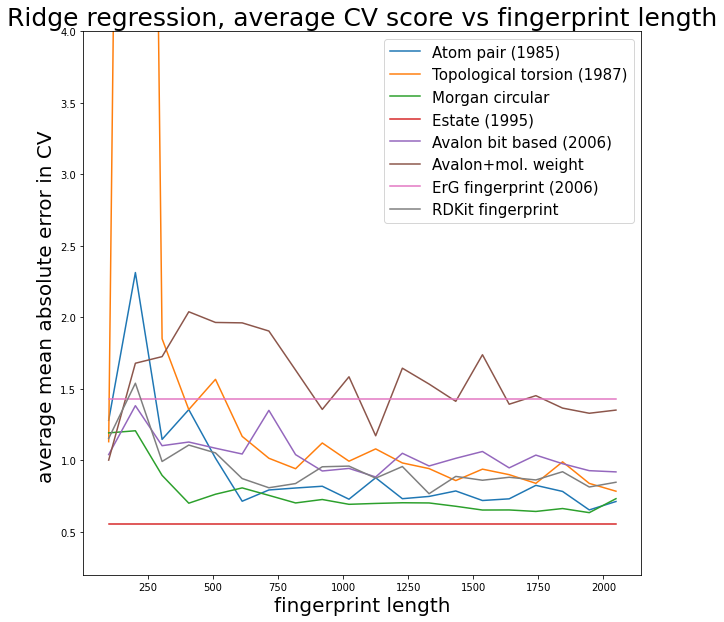

In [15]:
def test_fingerprint_vs_size(model, num_sizes_to_test=20, max_size=2048,cv=20,verbose=False, makeplots=False):
    fp_list =make_fingerprints(length=10)
    num_fp=len(fp_list)
    sizes=np.linspace(100, max_size, num_sizes_to_test)
    scores_vs_size= np.zeros([num_fp, num_sizes_to_test])
    num_fp=0
    for i in range(num_sizes_to_test):
        if verbose: print(i, ",", end='')
        length=sizes[i]
        fp_list=make_fingerprints(length=int(length))
        num_fp=len(fp_list)
        for j in range(num_fp):
            scores_vs_size[j,i]=test_model_cv(model,fp_list[j].x, y)
    
    if (makeplots):
        import matplotlib.pyplot as plt
        plt.clf()
        fig=plt.figure(figsize=(10,10))
        fp_names=[]
        for i in range(num_fp):
            plt.plot(sizes, scores_vs_size[i,:], '-')
            fp_names+=[fp_list[i].name]
        plt.title('Ridge regression, average CV score vs fingerprint length',fontsize=25)
        plt.ylabel('average mean absolute error in CV ',fontsize=20)
        plt.xlabel('fingerprint length', fontsize=20)
        plt.legend(fp_names,fontsize=15)
        plt.ylim([.2,4])
        plt.show()
    return scores_vs_size

scores_vs_size=test_fingerprint_vs_size(Ridge(alpha=1e-9), verbose=True, makeplots=True)

In [29]:
def estate_fingerprint(mol):
    return FingerprintMol(mol)[0]


data['Fingerprint']=data['Mol'].apply(estate_fingerprint)
X=np.array(list(data['Fingerprint']))
#print(X)
st=StandardScaler()
X=st.fit_transform(X)
#print(X)

0      [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, ...
1      [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 5, 1, 0, 0, ...
2      [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
3      [0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, ...
4      [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...
                             ...                        
158    [0, 0, 0, 0, 0, 0, 2, 1, 3, 0, 0, 0, 3, 0, 0, ...
159    [0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 1, 0, 0, ...
160    [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, ...
161    [0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 1, 0, 2, 0, 0, ...
162    [0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 3, 0, 2, 0, 0, ...
Name: Fingerprint, Length: 163, dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [30]:
KRmodel=GridSearchCV(KernelRidge(), cv=10, param_grid={"alpha":np.logspace(-10,-5,10), "gamma":np.logspace(-12,-9,10), "kernel":['laplacian', 'rbf']}, scoring='neg_mean_absolute_error', n_jobs=-1)

KRmodel=KRmodel.fit(X,y)
Best_KernelRidge=KRmodel.best_estimator_

print("Best Kernel Ridge model")
print(KRmodel.best_params_)
print(-1*KRmodel.best_score_)


Best Kernel Ridge model
{'alpha': 1.2915496650148826e-09, 'gamma': 1e-09, 'kernel': 'rbf'}
0.5535114693764378


In [31]:
Rmodel=GridSearchCV(Ridge(), cv=20, param_grid={"alpha": np.logspace(-10, -5, 30),}, scoring='neg_mean_absolute_error', n_jobs=-1)

Rmodel=Rmodel.fit(X, y)
Best_Ridge=Rmodel.best_estimator_

print("Best Ridge model")
print(Rmodel.best_params_)
print(-1*Rmodel.best_score_)

Best Ridge model
{'alpha': 1e-05}
0.5573758287057602


In [32]:
GPmodel=GridSearchCV(GaussianProcessRegressor(normalize_y=True),param_grid={"alpha": np.logspace(-15, -10, 30),}, scoring='neg_mean_absolute_error', n_jobs=-1)
GPmodel = GPmodel.fit(X, y)

Best_GaussianProcessRegressor = GPmodel.best_estimator_
print("Best Gaussian Process model")
print(GPmodel.best_params_)
print(-1*GPmodel.best_score_)

Best Gaussian Process model
{'alpha': 1e-15}
0.8729470576426749


In [33]:
RFmodel=GridSearchCV(RandomForestRegressor(), cv=20, param_grid={"n_estimators":np.linspace(50,150,25).astype('int')}, scoring='neg_mean_absolute_error', n_jobs=-1)
RFmodel=RFmodel.fit(X,y)
Best_RandomForestRegressor=RFmodel.best_estimator_
print("Best random Forest model")
print(RFmodel.best_params_)
print(-1*RFmodel.best_score_)

Best random Forest model
{'n_estimators': 54}
0.5564334927883972


<Figure size 432x288 with 0 Axes>

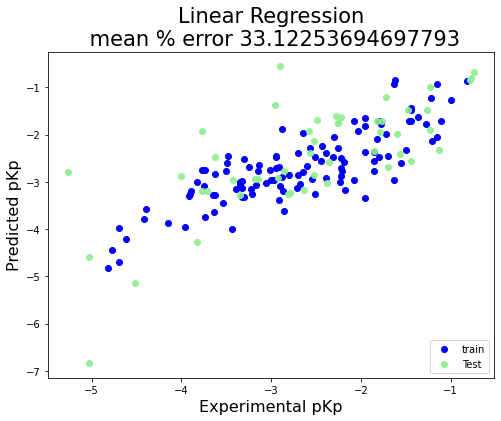

\begin{tabular}{c c c}
           name     &      % test err   & .    abs error in CV \\ 
\hline
             Linear Regression & 33.123 & 45835709773.189 \\
\end{tabular}


<Figure size 432x288 with 0 Axes>

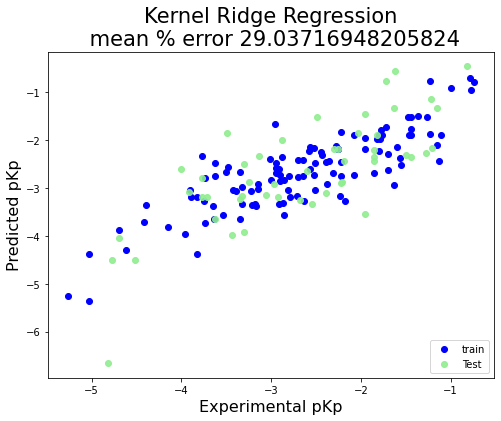

\begin{tabular}{c c c}
           name     &      % test err   & .    abs error in CV \\ 
\hline
       Kernel Ridge Regression & 29.037 & 0.548 \\
             Linear Regression & 33.123 & 45835709773.189 \\
\end{tabular}


<Figure size 432x288 with 0 Axes>

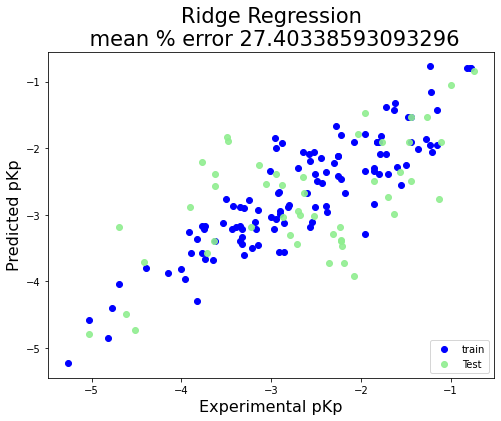

\begin{tabular}{c c c}
           name     &      % test err   & .    abs error in CV \\ 
\hline
       Kernel Ridge Regression & 29.037 & 0.548 \\
              Ridge Regression & 27.403 & 0.557 \\
             Linear Regression & 33.123 & 45835709773.189 \\
\end{tabular}


<Figure size 432x288 with 0 Axes>

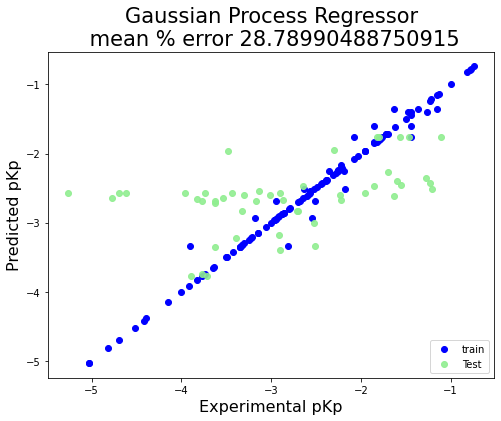

\begin{tabular}{c c c}
           name     &      % test err   & .    abs error in CV \\ 
\hline
       Kernel Ridge Regression & 29.037 & 0.548 \\
              Ridge Regression & 27.403 & 0.557 \\
    Gaussian Process Regressor & 28.790 & 0.917 \\
             Linear Regression & 33.123 & 45835709773.189 \\
\end{tabular}


<Figure size 432x288 with 0 Axes>

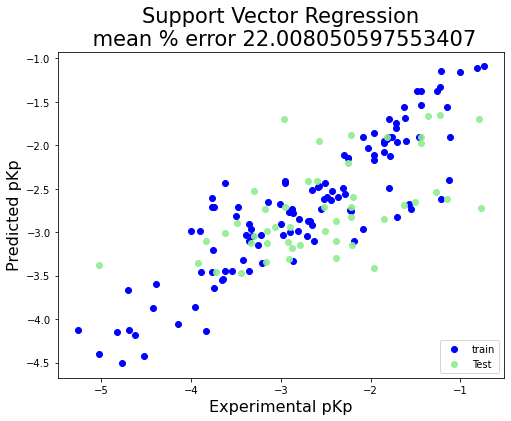

\begin{tabular}{c c c}
           name     &      % test err   & .    abs error in CV \\ 
\hline
       Kernel Ridge Regression & 29.037 & 0.548 \\
              Ridge Regression & 27.403 & 0.557 \\
     Support Vector Regression & 22.008 & 0.574 \\
    Gaussian Process Regressor & 28.790 & 0.917 \\
             Linear Regression & 33.123 & 45835709773.189 \\
\end{tabular}


<Figure size 432x288 with 0 Axes>

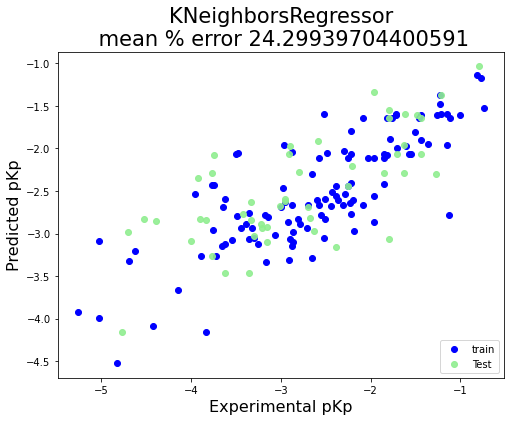

\begin{tabular}{c c c}
           name     &      % test err   & .    abs error in CV \\ 
\hline
       Kernel Ridge Regression & 29.037 & 0.548 \\
              Ridge Regression & 27.403 & 0.557 \\
     Support Vector Regression & 22.008 & 0.574 \\
           KNeighborsRegressor & 24.299 & 0.614 \\
    Gaussian Process Regressor & 28.790 & 0.917 \\
             Linear Regression & 33.123 & 45835709773.189 \\
\end{tabular}


<Figure size 432x288 with 0 Axes>

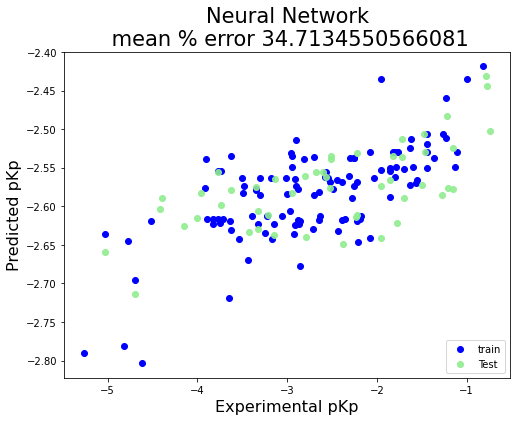

\begin{tabular}{c c c}
           name     &      % test err   & .    abs error in CV \\ 
\hline
       Kernel Ridge Regression & 29.037 & 0.548 \\
              Ridge Regression & 27.403 & 0.557 \\
     Support Vector Regression & 22.008 & 0.574 \\
           KNeighborsRegressor & 24.299 & 0.614 \\
                Neural Network & 34.713 & 0.724 \\
    Gaussian Process Regressor & 28.790 & 0.917 \\
             Linear Regression & 33.123 & 45835709773.189 \\
\end{tabular}


<Figure size 432x288 with 0 Axes>

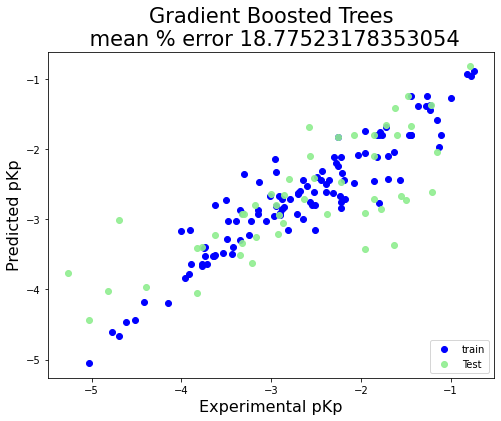

\begin{tabular}{c c c}
           name     &      % test err   & .    abs error in CV \\ 
\hline
       Kernel Ridge Regression & 29.037 & 0.548 \\
              Ridge Regression & 27.403 & 0.557 \\
        Gradient Boosted Trees & 18.775 & 0.559 \\
     Support Vector Regression & 22.008 & 0.574 \\
           KNeighborsRegressor & 24.299 & 0.614 \\
                Neural Network & 34.713 & 0.724 \\
    Gaussian Process Regressor & 28.790 & 0.917 \\
             Linear Regression & 33.123 & 45835709773.189 \\
\end{tabular}


<Figure size 432x288 with 0 Axes>

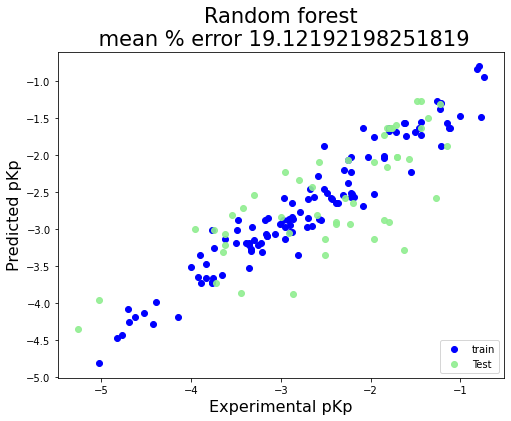

\begin{tabular}{c c c}
           name     &      % test err   & .    abs error in CV \\ 
\hline
       Kernel Ridge Regression & 29.037 & 0.548 \\
                 Random forest & 19.122 & 0.557 \\
              Ridge Regression & 27.403 & 0.557 \\
        Gradient Boosted Trees & 18.775 & 0.559 \\
     Support Vector Regression & 22.008 & 0.574 \\
           KNeighborsRegressor & 24.299 & 0.614 \\
                Neural Network & 34.713 & 0.724 \\
    Gaussian Process Regressor & 28.790 & 0.917 \\
             Linear Regression & 33.123 & 45835709773.189 \\
\end{tabular}


In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


def make_scatter_plot(y_pred_train, y_pred_test, y_train, y_test, title='', figsize=(6,4), fontsize=16):
    plt.clf()
    plt.figure(figsize=figsize)
    plt.scatter(y_train, y_pred_train, label='train', c='blue')
    plt.title(title, fontsize=fontsize+5)
    plt.xlabel('Experimental pKp', fontsize=fontsize)
    plt.ylabel('Predicted pKp', fontsize=fontsize)
    plt.scatter(y_test, y_pred_test, c='lightgreen', label='Test', alpha=0.9)
    plt.legend(loc=4)
    plt.show()

def test_models_and_plot(x,y,model_dict, plots=True):
  '''
  test sevral models and print 
  x: training data features
  y: training data labels
  model_dict: a dictionary of the form {name:model()},where name is a string and model() is the scikit-learn object.
  '''

  mean_scores={}
  percent_errors={}

  for (name, model) in model_dict.items():
      scores=cross_val_score(model, x, y,cv=20, n_jobs=-1, scoring='neg_mean_absolute_error')
      scores=-1*scores
      mean_score=scores.mean()
      mean_scores[name]=mean_score

      X_train, X_test, y_train, y_test= train_test_split(x, y, test_size=0.3)

      model.fit(X_train, y_train)

      y_pred_train=model.predict(X_train)
      y_pred_test=model.predict(X_test)
      percent_error=np.mean(100*np.abs(y_test-y_pred_test)/np.abs(y_pred_test))

      percent_errors[name]=percent_error

      fulltitle=name+'\n mean % error '+str(percent_error)

      if plots:
          make_scatter_plot(y_pred_train, y_pred_test, y_train,y_test, title=fulltitle, figsize=(8,6) )
       
      sorted_names=sorted(percent_errors, key=mean_scores.__getitem__, reverse=False)

      print("\\begin{tabular}{c c c}")
      print("           name     &      % test err   & .    abs error in CV \\\\ ")
      print("\\hline")

      for i in range(len(sorted_names)):
          name=sorted_names[i]
          print("%30s & %5.3f & %5.3f \\\\" % (name, percent_errors[name], mean_scores[name]))    
      print("\\end{tabular}")    


alpha_grid={'alpha':np.logspace(1e-11,1e-1,8)}

model_dict={'Linear Regression': LinearRegression(),
            'Kernel Ridge Regression': Best_KernelRidge,
            'Ridge Regression':Best_Ridge,
            'Gaussian Process Regressor': Best_GaussianProcessRegressor,
            'Support Vector Regression': SVR(),
            'KNeighborsRegressor': KNeighborsRegressor(),
            'Neural Network': MLPRegressor(alpha=100,max_iter=8000, hidden_layer_sizes=[8,6], early_stopping=False),           
            'Gradient Boosted Trees': GradientBoostingRegressor(n_estimators=100),
            'Random forest': Best_RandomForestRegressor
          }


test_models_and_plot(X, y, model_dict)

To sum up: The best-performing models are the Kernel Ridge regression followed by Random forest/Ridge regression and Gradient boosted trees.
